# Computational Thermofluid Dynamics - Chapter 2

Technical University of Munich, Professur für Thermofluiddynamik - Pr. Polifke

Created: 04/2024 | J. Yao, N. Garcia, G. Varillon

==============================================================================================

# Finite Differences
The 2D steady heat equation reads:
$$
\frac{\partial}{\partial x}(\lambda\frac{\partial T}{\partial x}) + \frac{\partial}{\partial y}(\lambda\frac{\partial T}{\partial y}) = 0
$$

In [2]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

class SteadyHeat2D:
    def __init__(self, Lx, Ly, dimX, dimY):
        self.Lx = Lx
        self.Ly = Ly
        self.dimX = dimX
        self.dimY = dimY
        self.dx = Lx / (dimX - 1)
        self.dy = Ly / (dimY - 1)
        self.A = lil_matrix((dimX * dimY, dimX * dimY))
        self.b = np.zeros(dimX * dimY)

    def idx(self, i, j):
        return i * self.dimY + j
    
    def set_inner(self):
        for i in range(1, self.dimX - 1):
            for j in range(1, self.dimY - 1):
                idx = self.idx(i, j)
                self.A[idx, self.idx(i, j)] = -4.0
                self.A[idx, self.idx(i-1, j)] = 1.0
                self.A[idx, self.idx(i+1, j)] = 1.0
                self.A[idx, self.idx(i, j-1)] = 1.0
                self.A[idx, self.idx(i, j+1)] = 1.0

    def set_south(self, bc_type, T_d=0.0, q=0.0, alpha=0.0, T_inf=0.0):
        j = 0
        for i in range(self.dimX):
            idx = self.idx(i, j)
            if bc_type == "Dirichlet":
                self.A[idx, idx] = 1.0
                self.b[idx] = T_d
            elif bc_type == "Neumann":
                self.A[idx, idx] = -1.0 / self.dy
                self.A[idx, self.idx(i, j + 1)] = 1.0 / self.dy
                self.b[idx] = q
            elif bc_type == "Robin":
                self.A[idx, idx] = -1.0 / self.dy + alpha
                self.A[idx, self.idx(i, j + 1)] = 1.0 / self.dy
                self.b[idx] = alpha * T_inf

    def set_north(self, bc_type, T_d=0.0, q=0.0, alpha=0.0, T_inf=0.0):
        j = self.dimY - 1
        for i in range(self.dimX):
            idx = self.idx(i, j)
            if bc_type == "Dirichlet":
                self.A[idx, idx] = 1.0
                self.b[idx] = T_d
            elif bc_type == "Neumann":
                self.A[idx, idx] = 1.0 / self.dy
                self.A[idx, self.idx(i, j - 1)] = -1.0 / self.dy
                self.b[idx] = q
            elif bc_type == "Robin":
                self.A[idx, idx] = 1.0 / self.dy + alpha
                self.A[idx, self.idx(i, j - 1)] = -1.0 / self.dy
                self.b[idx] = alpha * T_inf

    def set_east(self, bc_type, T_d=0.0, q=0.0, alpha=0.0, T_inf=0.0):
        i = self.dimX - 1
        for j in range(self.dimY):
            idx = self.idx(i, j)
            if bc_type == "Dirichlet":
                self.A[idx, idx] = 1.0
                self.b[idx] = T_d
            elif bc_type == "Neumann":
                self.A[idx, idx] = 1.0 / self.dx
                self.A[idx, self.idx(i - 1, j)] = -1.0 / self.dx
                self.b[idx] = q
            elif bc_type == "Robin":
                self.A[idx, idx] = 1.0 / self.dx + alpha
                self.A[idx, self.idx(i - 1, j)] = -1.0 / self.dx
                self.b[idx] = alpha * T_inf

    def set_west(self, bc_type, T_d=0.0, q=0.0, alpha=0.0, T_inf=0.0):
        i = 0
        for j in range(self.dimY):
            idx = self.idx(i, j)
            if bc_type == "Dirichlet":
                self.A[idx, idx] = 1.0
                self.b[idx] = T_d
            elif bc_type == "Neumann":
                self.A[idx, idx] = 1.0 / self.dx
                self.A[idx, self.idx(i + 1, j)] = -1.0 / self.dx
                self.b[idx] = q
            elif bc_type == "Robin":
                self.A[idx, idx] = 1.0 / self.dx + alpha
                self.A[idx, self.idx(i + 1, j)] = -1.0 / self.dx
                self.b[idx] = alpha * T_inf

    def solve(self):
        self.A = self.A.tocsr()
        T_flat = spsolve(self.A, self.b)
        self.T = T_flat.reshape((self.dimX, self.dimY))
        return self.T

    def plot(self):
        plt.imshow(self.T, extent=[0, self.Lx, 0, self.Ly], origin='lower', cmap='hot')
        plt.colorbar(label='Temperature')
        plt.title("2D Steady-State Temperature Distribution")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()


In [3]:
# Test case
Lx = 1.0
Ly = 1.0
dimX = 11
dimY = 11


heat = SteadyHeat2D(Lx, Ly, dimX, dimY)

heat.set_inner()
heat.set_south("Dirichlet", T_d=100.0)
heat.set_north("Dirichlet", T_d=50.0)
heat.set_east("Dirichlet", T_d=75.0)
heat.set_west("Dirichlet", T_d=25.0)


Temperature distribution matrix T:
[[ 25.          25.          25.          25.          25.
   25.          25.          25.          25.          25.
   25.        ]
 [100.          62.5         47.70055531  40.80222126  37.13653908
   35.05899377  33.96928978  33.76173117  34.82040122  38.60749904
   50.        ]
 [100.          77.29944469  62.5         53.37179064  47.68494129
   44.13014621  42.05643418  41.25723366  41.91237469  44.60959492
   50.        ]
 [100.          84.19777874  71.62820936  62.5         56.10128922
   51.7202156   48.86906708  47.29839461  46.96226895  47.91850596
   50.        ]
 [100.          87.86346092  77.31505871  68.89871078  62.5
   57.78035988  54.40122393  52.10500877  50.71980052  50.10215997
   50.        ]
 [100.          89.94100623  80.86985379  73.2797844   67.21964012
   62.5         58.85045999  56.00061601  53.70976439  51.77033341
   50.        ]
 [100.          91.03071022  82.94356582  76.13093292  70.59877607
   66.14954001  62.5 

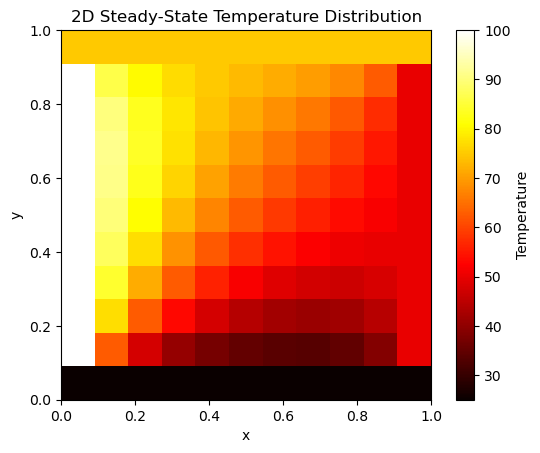

In [4]:

T = heat.solve()


print("Temperature distribution matrix T:")
print(T)


heat.plot()


In [5]:
# Test case
Lx = 1.0
Ly = 1.0
dimX = 11
dimY = 11


heat = SteadyHeat2D(Lx, Ly, dimX, dimY)

heat.set_inner()
heat.set_south("Neumann", T_d=100.0)
heat.set_north("Neumann", T_d=50.0)
heat.set_east("Neumann", T_d=75.0)
heat.set_west("Neumann", T_d=25.0)



Temperature distribution matrix T:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


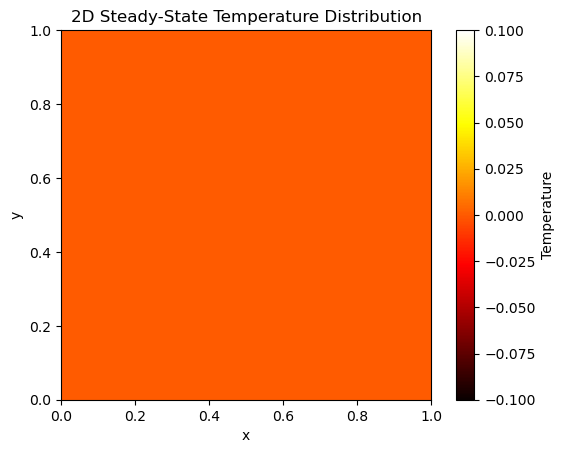

In [7]:

T = heat.solve()


print("Temperature distribution matrix T:")
print(T)


heat.plot()